(integration_model_class_template_label)=

# Workflow integration using model classes 

If you want to integrate tespy models in workflows, use the optimization
API of tespy or couple your models with other software it is very advisable to
create model classes, that control some of the interaction with the tespy model
and the user for you. Here we show, how this can be done.

```{tip}
This page is just to give you an idea on how you can set up such kind of
classes and what you can do with them. Note, that it is not feature complete
and the capabilities/methods will always somehow have to be adapted to your 
requirements.
```

## Models in workflows

If you are using your models in any kind of workflow or integration with other
software, then

- your model(s) will be likely be executed more than once
- you will retrieve specific results or run processing routines frequently
- you want to avoid model crashes or at least want them handled in some way
  without leaving side effects
- you may let users not knowing what is behind the model enter input data
- there might be the need for various tespy models doing similar things
  - various topologies
  - various working fluids
  - ...

## A possible solution using classes

We will present a possible solution to this problem, that has proved to be
quite efficient. However, this is not universal truth, this is what has been
working well. There might be better solutions, if you have any, please
suggest them or give some feedback to improve this suggestion. It is greatly
appreciated!

### Structure

The structure of the classes would look like this:

- there is one parent class which handles

  - setup of model instances
  - inputting and retrieving data from the model instances
  - solving models in design or offdesign mode (we will show design only here)
  - postprocessing result, e.g. plotting TQ diagrams of heat exchangers or 
    cycle diagrams of the process

- there are child classes which create the concrete tespy model

  - these set up the Network and create an initial stable solution
  - create mappings between external input parameters and the internals

This structure will help to nicely organize model input and output and 
automatically handle the solving of the models. In context of parameter input
and output, the following structure works well:

- use a dictionary of inputs, where the keys are mapped to specific parameters
  in the model, e.g. "evaporator_pinch" mapped to the parameter **td_pinch** of
  the **component** **evaporator** 
- internally an in-between layer of nested dictionaries is created which then
  is used to set parameters to the model or retrieve results, e.g.
  
  - user specifies {code}`{"evaporator_pinch": 10}`
  - in the parameter lookup we find:
    {code}`"evaporator_pinch": ["Components", "evaporator", "td_pinch"]`
  - this creates {code}`{"Components": {"evaporator": {"td_pinch": 10}}}`

- the reason for this is, that it integrates nicely with the optimization API

For the solving we have two methods, one that solves design case and one that
solves offdesign case. The purpose is to:

- solve the model
- check if the solve was successful with the {code}`status` attribute of the
  network
- handle potential errors in the solving or if the status is not 0

  - e.g handle what happens with converged simulation violating physical
    limits (status = 1)
  - e.g handle what happens with non-converged simulation (status = 2) or
    unexpected linear dependency (status = 3)
  - e.g handle what happens with crashed simulation (status = 99)

  ## Template

  With this set up, we can build our template:


In [1]:
from tespy.tools.helpers import merge_dicts
from tespy.networks import Network
import matplotlib.pyplot as plt
from fluprodia import FluidPropertyDiagram


DIAGRAMS = {}


class ModelTemplate():

    def __init__(self) -> None:
        self.parameter_lookup = self._parameter_lookup()
        self._create_network()

    def _create_network(self) -> None:
        self.nw = Network()
        self.nw.units.set_defaults(
            **{"temperature": "°C", "pressure": "bar"}
        )

    def _parameter_lookup(self) -> dict:
        return {}

    def _map_parameter(self, parameter: str) -> tuple:
        return self.parameter_lookup[parameter]

    def _map_to_input_dict(self, **kwargs) -> dict:
        input_dict = {}
        for param, value in kwargs.items():
            if param not in self.parameter_lookup:
                msg = (
                    f"The parameter {param} is not mapped to any input of the "
                    "model. The following parameters are available:\n"
                    f"{', '.join(self.parameter_lookup)}."
                )
                raise KeyError(msg)
            key = self._map_parameter(param)
            input_dict = merge_dicts(
                input_dict,
                {key[0]: {key[1]: {key[2]: value}}}
            )
        return input_dict

    def get_parameter(self, parameter: str) -> float:
        mapped = self._map_parameter(parameter)
        if mapped[0] == "Connections":
            return self.nw.get_conn(mapped[1]).get_attr(mapped[2]).val

        elif mapped[0] == "Components":
            return self.nw.get_comp(mapped[1]).get_attr(mapped[2]).val

    def set_parameters(self, **kwargs) -> None:
        input_dict = self._map_to_input_dict(**kwargs)
        if "Connections" in input_dict:
            for c, params in input_dict["Connections"].items():
                self.nw.get_conn(c).set_attr(**params)

        if "Components" in input_dict:
            for c, params in input_dict["Components"].items():
                self.nw.get_comp(c).set_attr(**params)

    def solve_model(self, **kwargs) -> None:
        self.set_parameters(**kwargs)

        self._solved = False
        self.nw.solve("design")

        if self.nw.status == 0:
            self._solved = True
        # is not required in this example, but could lead to handling some
        # stuff
        elif self.nw.status == 1:
            self._solved = False
        elif self.nw.status in [2, 3, 99]:
            # in this case model is very likely corrupted!!
            # fix it by running a presolve using the stable solution
            self._solved = False
            self.nw.solve("design", init_only=True, init_path=self._stable_solution)

    def plot_Ts_diagram(self) -> plt.Figure:
        fig, ax = plt.subplots(1)
        return fig, ax

## Concrete model

For example, let us build a model that implements an Organic Rankine Cycle
with internal heat recuperator. We now only need to define the
{code}`_parameter_lookup` method for the concrete model and set up the model in
the {code}`_create_network` method. 

Next to setting up the structure of the model, that method has one main
purpose: Make an initial (or multiple) solves, that guarantee a stable solution
to start with for the future. For this reason, we start with a specification
that is very simple to solve (pressure and temperatures given), solve the model
and only then switch inputs to more usable ones (pinches, efficiencies etc.). 
We solve the model again and save the solution to a file, from where we can
always reload the solution to initialize a future model run, when the starting
values of a model run become corrupted (e.g. because of unexpected model
crashes or model non-convergence).

In [2]:
from tespy.components import Turbine, MovingBoundaryHeatExchanger, CycleCloser, Pump, Source, Sink, Generator, PowerBus, PowerSink, Motor
from tespy.connections import Connection, PowerConnection
from tespy.tools import get_plotting_data


class ORCModel(ModelTemplate):

    def _parameter_lookup(self) -> dict:
        return {
            "evaporator_pinch": ["Components", "evaporator", "td_pinch"],
            "condenser_pinch": ["Components", "condenser", "td_pinch"],
            "turbine__efficiency": ["Components", "turbine", "eta_s"],
            "net_power": ["Connections", "e5", "E"],
            "T_source": ["Connections", "a1", "T"],
            "T_outflow": ["Connections", "a3", "T"],
            "m_source": ["Connections", "a1", "m"]
        }

    def _create_network(self) -> None:

        super()._create_network()

        turbine = Turbine("turbine")
        recuperator = MovingBoundaryHeatExchanger("recuperator")
        condenser = MovingBoundaryHeatExchanger("condenser")
        pump = Pump("pump")
        preheater = MovingBoundaryHeatExchanger("preheater")
        evaporator = MovingBoundaryHeatExchanger("evaporator")
        cc = CycleCloser("cc")

        heat_source = Source("heat source")
        heat_outflow = Sink("heat outflow")

        air_source = Source("air source")
        air_sink = Sink("air sink")

        a1 = Connection(heat_source, "out1", evaporator, "in1", label="a1")
        a2 = Connection(evaporator, "out1", preheater, "in1", label="a2")
        a3 = Connection(preheater, "out1", heat_outflow, "in1", label="a3")

        b1 = Connection(cc, "out1", turbine, "in1", label="b1")
        b2 = Connection(turbine, "out1", recuperator, "in1", label="b2")
        b3 = Connection(recuperator, "out1", condenser, "in1", label="b3")
        b4 = Connection(condenser, "out1", pump, "in1", label="b4")
        b5 = Connection(pump, "out1", recuperator, "in2", label="b5")
        b6 = Connection(recuperator, "out2", preheater, "in2", label="b6")
        b7 = Connection(preheater, "out2", evaporator, "in2", label="b7")
        b8 = Connection(evaporator, "out2", cc, "in1", label="b8")

        c1 = Connection(air_source, "out1", condenser, "in2", label="c1")
        c2 = Connection(condenser, "out2", air_sink, "in1", label="c2")

        self.nw.add_conns(a1, a2, a3, b1, b2, b3, b4, b5, b6, b7, b8, c1, c2)

        generator = Generator("generator")
        motor = Motor("motor")
        power_bus = PowerBus("bus", num_in=1, num_out=2)
        grid = PowerSink("grid")

        e1 = PowerConnection(turbine, "power", generator, "power_in", label="e1")
        e2 = PowerConnection(generator, "power_out", power_bus, "power_in1", label="e2")
        e3 = PowerConnection(power_bus, "power_out1", motor, "power_in", label="e3")
        e4 = PowerConnection(motor, "power_out", pump, "power", label="e4")
        e5 = PowerConnection(power_bus, "power_out2", grid, "power", label="e5")

        self.nw.add_conns(e1, e2, e3, e4, e5)

        generator.set_attr(eta=0.98)
        motor.set_attr(eta=0.98)

        a1.set_attr(fluid={"air": 1}, T=200, p=1, m=10)
        a2.set_attr(T=155)

        b1.set_attr(fluid={"Isopentane": 1}, x=1, T=150)

        b3.set_attr(td_dew=10, T_dew=30)
        b4.set_attr(td_bubble=5)
        b7.set_attr(td_bubble=5)

        c1.set_attr(fluid={"air": 1}, T=10, p=1)
        c2.set_attr(T=20)

        recuperator.set_attr(dp1=0, dp2=0)
        condenser.set_attr(dp1=0, dp2=0)
        preheater.set_attr(dp1=0, dp2=0)
        evaporator.set_attr(dp1=0, dp2=0)

        turbine.set_attr(eta_s=0.8)
        pump.set_attr(eta_s=0.7)

        self.nw.solve("design")

        b3.set_attr(T_dew=None)
        condenser.set_attr(td_pinch=5)

        a2.set_attr(T=None)
        evaporator.set_attr(td_pinch=10)

        self.nw.solve("design")
        self._stable_solution = "stable_solution.json"
        self.nw.save(self._stable_solution)

    def plot_Ts_diagram(self):
        fig, ax = super().plot_Ts_diagram()

        if "Isopentane" not in DIAGRAMS:
            # if not already available we will create one
            diagram = FluidPropertyDiagram("Isopentane")
            # these are hard coded right now, but could be flexible of course
            diagram.set_unit_system(**{"T": "°C", "p": "bar"})
            diagram.set_isolines_subcritical(0, 250)
            diagram.calc_isolines()
            DIAGRAMS["Isopentane"] = diagram

        diagram = DIAGRAMS["Isopentane"]
        processes, points = get_plotting_data(self.nw, "b1")

        processes = {
            key: diagram.calc_individual_isoline(**value)
            for key, value in processes.items()
            if value is not None

        }

        diagram.draw_isolines(fig, ax, "Ts", -200, 1750, 0, 250)

        for label, values in processes.items():
            _ = ax.plot(values["s"], values["T"], label=label, color="tab:red")

        for label, point in points.items():
            _ = ax.scatter(point["s"], point["T"], label=label, color="tab:red")

        return fig, ax

## Make use of the model

With the model ready to use, we can set up an instance. We see two times
solving iterations.

In [3]:
model = ORCModel()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 3.25e+06   | 0 %        | 7.83e+01   | 0.00e+00   | 3.25e+05   | 0.00e+00   | 3.43e+05   
 2     | 2.15e+05   | 7 %        | 1.63e-09   | 0.00e+00   | 8.45e+04   | 0.00e+00   | 1.19e+05   
 3     | 3.33e-02   | 83 %       | 1.54e-15   | 0.00e+00   | 4.09e-03   | 0.00e+00   | 3.01e-03   
 4     | 1.86e-10   | 100 %      | 1.01e-14   | 0.00e+00   | 2.85e-11   | 0.00e+00   | 3.13e-11   
 5     | 5.29e-10   | 100 %      | 1.01e-14   | 0.00e+00   | 5.40e-11   | 0.00e+00   | 5.59e-11   
Total iterations: 5, Calculation time: 0.01 s, Iterations per second: 590.31

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 5.67e+00   | 58 %    

 5     | 9.33e-10   | 100 %      | 8.68e-14   | 3.80e-10   | 3.77e-10   | 0.00e+00   | 4.31e-10   
Total iterations: 5, Calculation time: 0.07 s, Iterations per second: 76.91


And then we can resolve it easily with updated input parameters:

In [4]:
model.solve_model(
    **{"T_source": 225}
)


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.57e+05   | 6 %        | 4.77e+01   | 6.13e-24   | 3.36e+04   | 0.00e+00   | 1.62e+05   
 2     | 1.83e-04   | 100 %      | 3.24e-04   | 1.98e-10   | 4.44e-01   | 0.00e+00   | 1.10e+00   
 3     | 3.87e-09   | 100 %      | 4.12e-12   | 3.26e-11   | 5.13e-09   | 0.00e+00   | 1.42e-08   
 4     | 5.18e-09   | 100 %      | 3.25e-14   | 7.53e-12   | 5.58e-10   | 0.00e+00   | 8.08e-10   
Total iterations: 4, Calculation time: 0.09 s, Iterations per second: 44.18


And we can retrieve some results:

In [5]:
model.get_parameter("T_outflow")

72.41164019435348

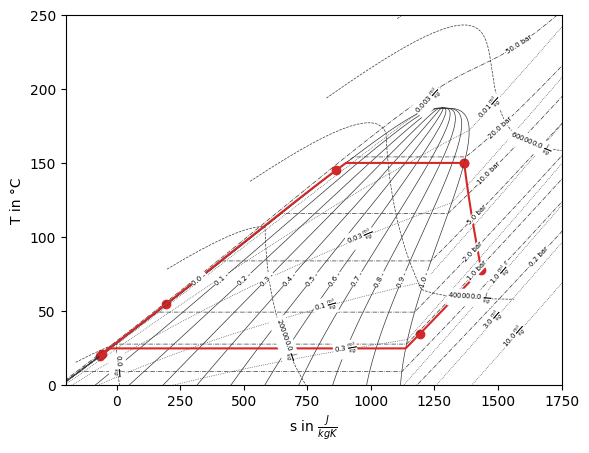

In [6]:
fig, ax = model.plot_Ts_diagram()